<a href="https://colab.research.google.com/github/JancerGomes/concedidos-inss/blob/master/An%C3%A1lise_INSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ánalise de Benefícios Concedidos


In [ ]:
# Imports necessários
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
abril = pd.read_csv('https://drive.google.com/uc?export=download&id=1zQj9Gj7FmrajtBZcDoZ4DyRR4D-4vWGh', encoding='latin1', sep=';')

In [ ]:
# Carregando os dados em um Data Frame
maio = pd.read_csv('https://drive.google.com/uc?export=download&id=1ktiM8UJcSGB4MOOn5VcIl3qdEI-we44Z', encoding='latin1', sep=';')

In [ ]:
junho = pd.read_csv('https://drive.google.com/uc?export=download&id=1-MsqtOgw8SZTasQk-QCLFdJ-H2M8An59', encoding='latin1', sep=';')

Os conjuntos de dados em questão não trazem um *dicionário de dados*, isto é, uma descrição das informações trazidas em cada coluna. Sendo assim, faço um esboço abaixo, através do que se pode inferir pelos rótulos e valores da tabela.

**Competência concessão**: indicação da competência (mês e ano) em que o benefício foi concedido (formato "AAAAMM", ex: 202006)

**Espécie**: espécie do benefício (auxílio-doença, aposentadoria por idade etc)

**CID**: código da patologia relacionada à incapacidade laboral, para os benefícios aplicáveis, de acordo com a Classificação Internacional de Doenças, em formato simples (ex:m501).

**CID.1**: código CID com descrição (ex:M50.1 Transt do Disco Cervical c/Radiculopatia)

**Despacho**: modalidade da concessão (ex: normal, decorrente de ação judicial, com conversão de tempo de serviço etc)

**Dt Nascimento**: data de nascimento do beneficiário.

**Sexo.**: sexo do beneficiário

**Mun Resid**: município onde o beneficiário reside.

**Vínculo dependentes**: relação do beneficiário com o instituidor do benefício (ex: filho, esposa), ou relação de parentesco geradora de salário maternidade (filho ou filho adotivo).

**Forma filiação**: como o beneficiário é filiado ao INSS (empregado, autônomo, segurado especial)

**UF**: unidade federativa da Agência da Previdência Social (APS) que concedeu o benefício.

**Qt SM RMI**: valor da Renda Mensal Inicial (RMI) em salários-mínimos.

Neste notebook, analisaremos os benefícios concedidos no segundo trimestre de 2020.
Teremos um retrato da ação do INSS no período de pandemia

In [ ]:
seg_tri2020 = pd.concat([abril, maio, junho], ignore_index=True)

In [ ]:
seg_tri2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231287 entries, 0 to 1231286
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Competência concessão  1231287 non-null  int64 
 1   Espécie                1231287 non-null  object
 2   CID                    1231287 non-null  object
 3   CID.1                  1231287 non-null  object
 4   Despacho               1231287 non-null  object
 5   Dt Nascimento          1231287 non-null  object
 6   Sexo.                  1231287 non-null  object
 7   Mun Resid              1231287 non-null  object
 8   Vínculo dependentes    1231287 non-null  object
 9   Forma Filiação         1231287 non-null  object
 10  UF                     1231287 non-null  object
 11  Qt SM RMI              1231287 non-null  object
dtypes: int64(1), object(11)
memory usage: 112.7+ MB


In [ ]:
# Extraindo uma amostra aleatória de linhas
# (processo repetido algumas vezes)
seg_tri2020.sample(10)

,Competência concessão,Espécie,CID,CID.1,Despacho,Dt Nascimento,Sexo.,Mun Resid,Vínculo dependentes,Forma Filiação,UF,Qt SM RMI
965729,202006,Auxílio Doenca Previdenciário,m544,M54.4 Lumbago c/Ciatica,Concessao Normal,23/03/1971,Feminino,21402-SP-Pongaí,Não Informado,Autônomo,São Paulo,"1,000"
1207481,202006,Auxílio Doenca Previdenciário,z35,Z35 Supervisao de Gravidez de Alto Risco,Concessao Normal,29/10/1991,Feminino,14053-PR-Cianorte,Não Informado,Desempregado,Paraná,"1,000"
16261,202004,Pensão por Morte Previdenciária,000000,Zerados,Concessao Normal,05/02/1971,Feminino,05128-CE-Senador Pompeu,Cônjuge,Segurado Especial,Paraíba,"1,000"
835149,202006,Aposentadoria por Tempo de Contribuição,000000,Zerados,Concessao Decorrente de Acao Judicial,21/07/1971,Masculino,02010-AL-Boca da Mata,Não Informado,Empregado,Pernambuco,"1,002"
533206,202005,Aposentadoria por Tempo de Contribuição,000000,Zerados,Concessao Decorrente de Acao Judicial,01/08/1963,Feminino,13041-PB-Campina Grande,Não Informado,Empregado,Ceará,"1,000"
162591,202004,{ñ class},000000,Zerados,Concessao Normal,11/10/2015,Masculino,15116-PE-Recife,Não Informado,Desempregado,Pernambuco,"0,574"
735955,202005,Auxílio Doenca Previdenciário,s826,S82.6 Frat do Maleolo Lateral,Concessao Normal,03/03/1986,Masculino,15064-PE-Gravatá,Não Informado,Empregado,Pernambuco,"1,000"
143213,202004,{ñ class},000000,Zerados,Concessao Normal,30/05/2001,Masculino,12068-PA-Santarém,Não Informado,Desempregado,Pará,"0,574"
560766,202005,Auxílio Doenca Previdenciário,k810,K81.0 Colecistite Aguda,Concessao Normal,16/03/1990,Feminino,11667-MG-Serra dos Aimorés,Não Informado,Autônomo,Minas Gerais,"1,000"
604554,202005,Auxílio Doenca Previdenciário,m511,M51.1 Transt Disco Lombar Outr Intervert Radi,Concessao Normal,13/11/1962,Feminino,20238-SC-Santa Helena,Não Informado,Autônomo,Santa Catarina,"1,000"


Após uma verificação preliminar dos dados, já podemos tomar algumas medidas que facilitarão a análise:

1. Substituir os valores da coluna 'Competência concessão' apenas pelo mês correspondente, renomeando de acordo;
  - Aproveitemos para converter cada mês para o tipo de categoria ordenada, algo que será útil num ponto posterior da análise;
2. Remover a redundância de CID, mantendo apenas a coluna com maior detalhe;
3. Retirar o código do município de residência, visto que é irrelevante para nossa análise;
4. Converter valores de RMI para o formato numérico;
5. Renomear colunas, facilitando a manipulação;
6. Vamos substituir o termo "Não Informado", na coluna _Vínculo dependentes_ por "NaN" - uma forma apropriada de representar a nulidade em Python;
7. Converter coluna _"Dt Nascimento"_ para o formato datetime.
  - Criar uma coluna idade

In [ ]:
# Passo 1
seg_tri2020 = seg_tri2020.replace({'Competência concessão':{202004:'Abril',202005:'Maio',202006:'Junho'}}).rename(columns={'Competência concessão':'Mês'})
seg_tri2020.Mês = pd.Categorical(seg_tri2020.Mês, ordered=True,
                       categories=['Abril','Maio','Junho'])

# Passo 2
seg_tri2020 = seg_tri2020.drop('CID', 1)

# Passo 3
seg_tri2020['Mun Resid'] = seg_tri2020['Mun Resid'].str.extract(r'.*?-(.*)')

# Passo 4
seg_tri2020['Qt SM RMI'] = seg_tri2020['Qt SM RMI'].str.replace(',','.').astype('float')

# Passo 5
seg_tri2020.rename(columns={'Sexo.':'Sexo', 'CID.1':'CID', 'Qt SM RMI':'RMI em SM'}, inplace=True)

# Passo 6
seg_tri2020['Vínculo dependentes'].replace('Não Informado',np.nan, inplace=True)

#Passo 7
seg_tri2020['Dt Nascimento'] = pd.to_datetime(seg_tri2020['Dt Nascimento'], 'coerce', dayfirst=True)
#
from pandas.tseries.offsets import MonthEnd
for mês, num_mês in zip(seg_tri2020['Mês'].unique(), (4,5,6)):
  fim_do_mês = pd.Timestamp(year=2020, month=num_mês, day=1) + MonthEnd(0)
  nascimento = seg_tri2020.loc[seg_tri2020.Mês == mês,'Dt Nascimento']
  seg_tri2020.loc[seg_tri2020.Mês == mês,'Idade'] = (fim_do_mês - nascimento).astype('timedelta64[Y]')
seg_tri2020.Idade = seg_tri2020.Idade.astype('Int32')

# Resultado
seg_tri2020.sample(10)

,Mês,Espécie,CID,Despacho,Dt Nascimento,Sexo,Mun Resid,Vínculo dependentes,Forma Filiação,UF,RMI em SM,Idade
573394,Maio,Auxílio Doenca Previdenciário,N90.8 Outr Transt Nao-Inflam Espec Vulva e Pe,Concessao Normal,1969-01-14,Feminino,PR-Candói,NaN,Autônomo,Paraná,1.000,51
357130,Abril,Aposentadoria por Tempo de Contribuição,Zerados,Concessao Decorrente de Acao Judicial,1955-12-22,Masculino,SP-São Paulo,NaN,Empregado,São Paulo,2.988,64
361339,Abril,Aposentadoria por Tempo de Contribuição,Zerados,Concessao Normal,1956-05-06,Masculino,SP-São Paulo,NaN,Autônomo,São Paulo,1.198,63
432132,Abril,Aposentadoria por Idade,Zerados,Concessao Normal,1955-03-14,Masculino,RS-Porto Alegre,NaN,Autônomo,São Paulo,1.000,65
160541,Abril,{ñ class},Zerados,Concessao Normal,1986-09-13,Masculino,PE-Jaboatão dos Guararapes,NaN,Desempregado,Pernambuco,0.574,33
265901,Abril,Aposentadoria por Tempo de Contribuição,Zerados,Concessao Normal,1967-10-06,Feminino,ES-Marechal Floriano,NaN,Autônomo,Sergipe,1.000,52
97596,Abril,{ñ class},Zerados,Concessao Normal,1959-07-02,Feminino,GO-Niquelândia,NaN,Desempregado,Goiás,0.574,60
616559,Maio,Aposentadoria por Idade,Zerados,Concessao Normal,1959-07-07,Feminino,SP-Presidente Prudente,NaN,Facultativo,São Paulo,1.000,60
1080997,Junho,Auxilio União,Zerados,Concessao Normal,1967-10-12,Masculino,AM-Manaus,NaN,Desempregado,Distrito Federal,0.574,52
522968,Maio,Auxílio Doenca Previdenciário,S52.5 Frat da Extremidade Distal do Radio,Concessao Normal,1985-06-10,Masculino,BA-Salvador,NaN,Empregado,Bahia,1.000,34


É possível verificar que a variável _Espécie_, em algumas linhas, possui o texto "{ñ class}". Examinemos o quanto isso aparece:


In [ ]:
seg_tri2020.loc[seg_tri2020.Espécie == '{ñ class}','Espécie'].count()

146021

Esse preenchimento ocorre em 146.021 linhas, o que equivale a quase 10% de nosso dataset.
Nas amostras examinadas, foi possível verificar que o valor associado ao benefício é o de 0,574 salário mínimo. Feita a devida multiplicação, verificamos que o resultado se aproxima muito de 600 reais - a renda do auxílio emergencial. Verifiquemos se isso é uma constante:

In [ ]:
seg_tri2020.loc[seg_tri2020.Espécie=='{ñ class}', 'RMI em SM'].value_counts()

0.574    146021
Name: RMI em SM, dtype: int64

Podemos verificar que todos os benefícios categorizados como "{ñ class}" são referentes ao adiantamento de valor previsto na Lei do auxílio emergencial.
Percebe-se também que, no restante dos dados, tal adiantamento é tratado como "Auxilio União"(sem acento), então substituiremos o termo acima por essa nomenclatura, corrigindo ainda a ortografia:

In [ ]:
seg_tri2020.loc[seg_tri2020.Espécie.isin(['{ñ class}','Auxilio União']),'Espécie'] = 'Auxílio União'

## Distribuição dos salários por estado


In [ ]:
seg_tri2020.groupby('UF')['RMI em SM'].mean().sort_values(ascending=False)

UF
São Paulo              1.296354
Rio Grande do Sul      1.196501
Paraná                 1.175267
Acre                   1.173024
Santa Catarina         1.161889
Piauí                  1.159372
Rio de Janeiro         1.142534
Rio Grande do Norte    1.132928
Espírito Santo         1.123567
Goiás                  1.122381
Minas Gerais           1.117703
Alagoas                1.116435
Tocantins              1.110879
Sergipe                1.109152
Paraíba                1.104235
Bahia                  1.103781
Rondônia               1.102245
Pernambuco             1.097438
Mato Grosso do Sul     1.089203
Ceará                  1.084142
Mato Grosso            1.070564
Distrito Federal       1.070320
Maranhão               1.064916
Amapá                  1.034164
Pará                   1.012322
Amazonas               0.997148
Roraima                0.952110
Name: RMI em SM, dtype: float64

## Análise CIDs

Em relação aos benefícios ligados à presença de alguma patologia, verificamos que há um CID descrito.

Vemos que algumas colunas possuem o termo 'Zerados', referente à ausência de valores. 


In [ ]:
seg_tri2020.loc[~seg_tri2020.CID.str.match(r'[A-Z][0-9]'), 'CID'].unique()

array(['Zerados', '{ñ class}', 'Em Branco', '020  Peste',
       '062  Encefalite Viral Transmit por Mosquitos',
       '340  Esclerose Multipla'], dtype=object)

In [ ]:
# Substituição:
seg_tri2020.CID.replace(['Zerados', '{ñ class}', 'Em Branco'], np.nan, inplace=True)

Após realizar as substituições, podemos localizar apenas os benefícios com um CID não nulo, isto é, aqueles relacionados a alguma patologia.

In [ ]:
benefs_CID = seg_tri2020.loc[seg_tri2020.CID.notnull()]
benefs_CID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441099 entries, 32 to 1231262
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Mês                  441099 non-null  category      
 1   Espécie              441099 non-null  object        
 2   CID                  441099 non-null  object        
 3   Despacho             441099 non-null  object        
 4   Dt Nascimento        441095 non-null  datetime64[ns]
 5   Sexo                 441099 non-null  object        
 6   Mun Resid            440959 non-null  object        
 7   Vínculo dependentes  7465 non-null    object        
 8   Forma Filiação       441099 non-null  object        
 9   UF                   441099 non-null  object        
 10  RMI em SM            441099 non-null  float64       
 11  Idade                441095 non-null  Int32         
dtypes: Int32(1), category(1), datetime64[ns](1), float64(1), object(8)
mem

In [ ]:
benefs_CID.Espécie.value_counts()

Auxílio Doenca Previdenciário               433384
Aposentadoria Invalidez Previdenciária        3079
Auxílio Doenca por Acidente do Trabalho       2822
Amp. Social Pessoa Portadora Deficiencia      1130
Auxílio Acidente Previdenciário                244
Auxílio Acidente                               177
Auxílio Salario Maternidade                    134
Aposent. Invalidez Acidente Trabalho           107
Pensão por Morte Previdenciária                 19
Amparo Social ao Idoso                           3
Name: Espécie, dtype: int64

Vemos que o Auxílio-doença Previdenciário naturalmente contém o maior número de concessões associadas a males de saúde.

Vamos investigar quais os CIDs frequentes dentro as cinco primeiras espécies de benefício deste subgrupo:

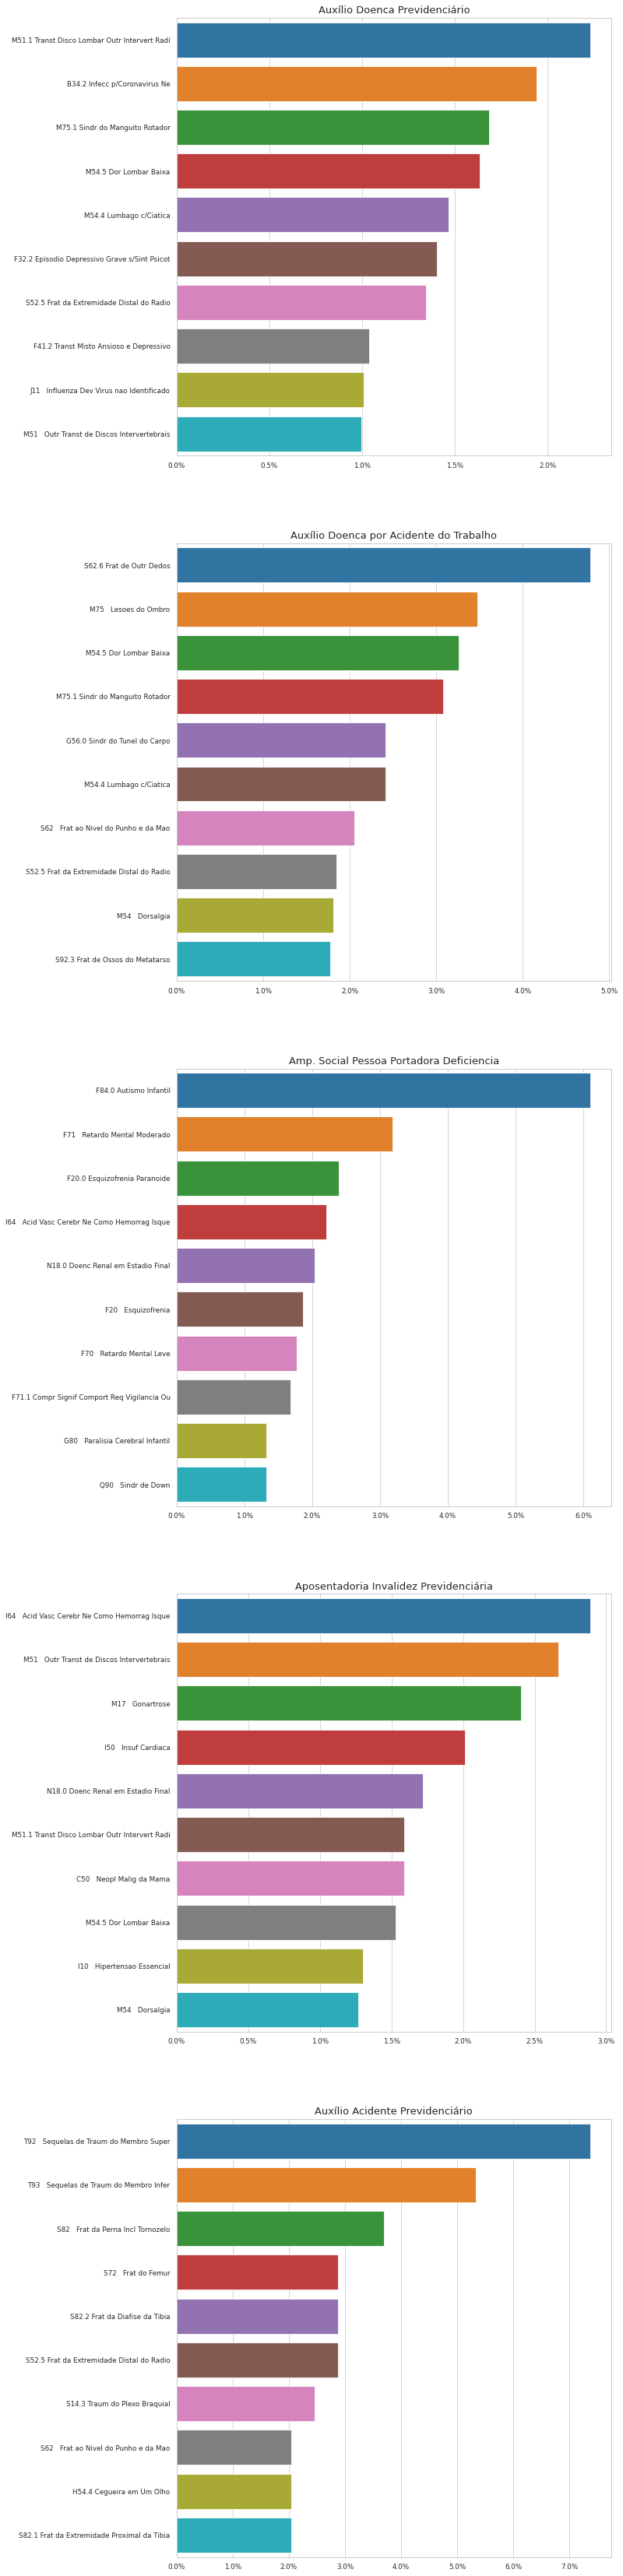

In [ ]:
from matplotlib.ticker import PercentFormatter
sns.set_style('whitegrid')
sns.set_context('paper')
fig, axs = plt.subplots(5, figsize=(10,60))

lista_CID = ['Auxílio Doenca Previdenciário',
             'Auxílio Doenca por Acidente do Trabalho',
             'Amp. Social Pessoa Portadora Deficiencia',
             'Aposentadoria Invalidez Previdenciária',
             'Auxílio Acidente Previdenciário']
for i, especie in zip(axs.flat, lista_CID):
  top10 = benefs_CID.loc[benefs_CID.Espécie == especie, 'CID'].value_counts(normalize=True)[:10]
  plot = sns.barplot(top10.values, top10.index, ax=i)
  plot.set_title(especie, fontdict={'fontsize':13})
  plot.xaxis.set_major_formatter(PercentFormatter(1, decimals=1))
  

Um detalhe interessante é a patologia que ocupa a segunda posição entre aquelas ensejadoras de AD Previdenciário: **Infecção por coronavírus**. É mais um dos inúmeros impactos da pandemia. Mesmo quando o trabalhador não é acometido de um quadro grave, se faz necessário o afastamento para evitar a transmissão.

Para essa espécie, bem como para sua equivalente acidentária, podemos observar uma presença significante de CIDs iniciados em M - [Doenças do sistema osteomuscular e do tecido conjuntivo.](https://pt.wikipedia.org/wiki/CID-10_Cap%C3%ADtulo_XIII:_Doen%C3%A7as_do_sistema_osteomuscular_e_do_tecido_conjuntivo)

Voltando o olhar para o Benefício de Prestação Continuada (BPC) cedido para pessoas com deficiência, podemos observar sua importância para a subsistência daqueles diagnosticados com autismo infantil, retardo mental e síndrome de Down, por exemplo.




## Análise salarial

Passemos à observação dos valores de Renda Mensal Inicial. 

### Por espécie

Primeiramente, verifiquemos quantas espécies previdenciárias temos no *dataset*:

In [ ]:
print('A quantidade de espécies é', seg_tri2020.Espécie.nunique())

A quantidade de espécies é 30


Por questões práticas, se faz necessário limitar essa parcela da análise aos benefícios com maior número de concessões. Vamos selecionar os dez primeiros lugares e organizá-los em um dataframe:

In [ ]:
# Top 10 espécies
especies_princ = seg_tri2020.Espécie.value_counts().index[:10]
dados_top10 = seg_tri2020.loc[seg_tri2020.Espécie.isin(especies_princ)]
dados_top10.head()

,Mês,Espécie,CID,Despacho,Dt Nascimento,Sexo,Mun Resid,Vínculo dependentes,Forma Filiação,UF,RMI em SM,Idade
0,Abril,Aposentadoria por Idade,NaN,Concessao Normal,1965-02-22,Feminino,BA-Utinga,NaN,Segurado Especial,Alagoas,1.000,55
1,Abril,Aposentadoria por Tempo de Contribuição,NaN,Concessao Normal,1968-10-28,Masculino,PB-Campina Grande,NaN,Empregado,Alagoas,3.198,51
2,Abril,Aposentadoria por Idade,NaN,Concessao Normal,1959-08-14,Feminino,RJ-Niterói,NaN,Desempregado,Alagoas,1.161,60
3,Abril,Aposentadoria por Idade,NaN,Concessao Normal,1954-12-22,Masculino,RS-Novo Hamburgo,NaN,Autônomo,Alagoas,1.000,65
4,Abril,Aposentadoria por Idade,NaN,Concessao Normal,1958-06-27,Feminino,RS-Encantado,NaN,Autônomo,Alagoas,1.000,61


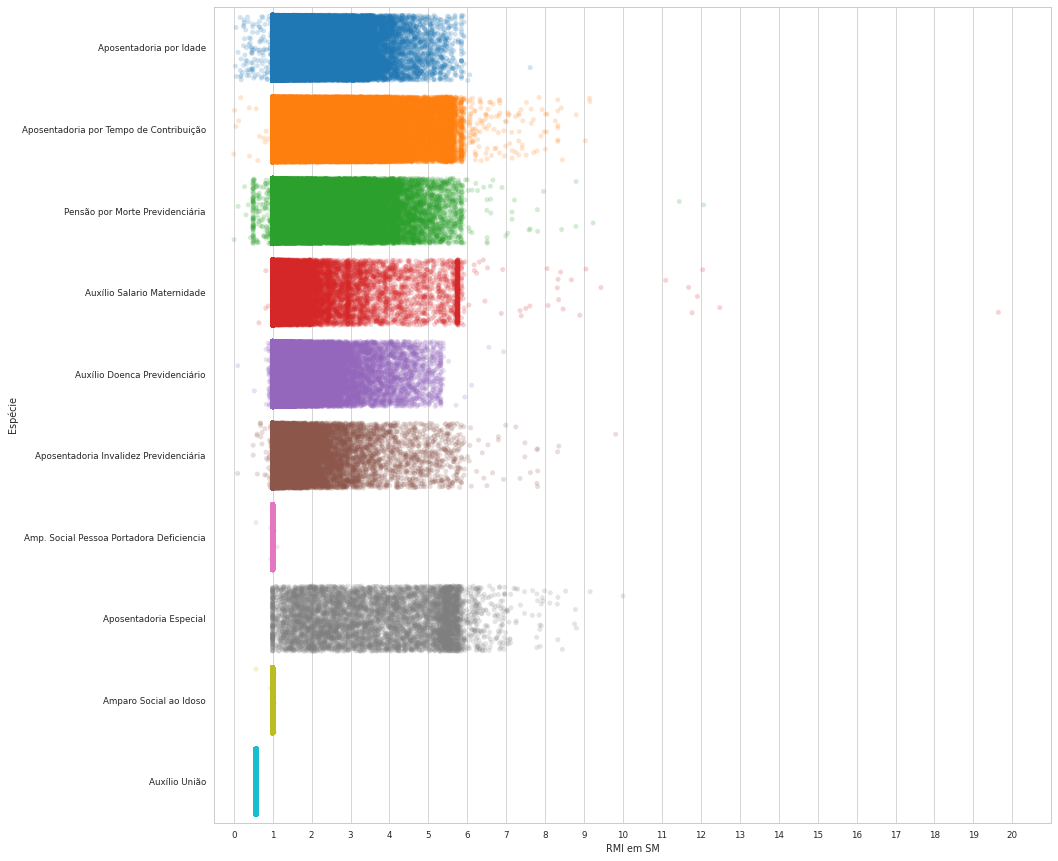

In [ ]:
plt.figure(figsize=((15,15)))
sns.stripplot('RMI em SM', 'Espécie',  data=dados_top10, jitter=.4, alpha=.2)
plt.xticks(np.linspace(0,20,21));
plt.xlim(-.5,21);

As rendas mensais iniciais do adiantamento associado ao Auxílio Emergencial possuem um único valor (R$ 600,00). 

Já nas espécies de amparo social, o valor predominante é o de um salário mínimo, visto que este é definido em lei. Há pequenas flutuações para baixo; essas podem ser atribuídas a concessões retardatárias, isto é, de benefícios solicitados em anos anteriores, quando o salário mínimo era menor. Já as (pouquíssimas) flutuações positivas podem ser resultado de erro no preenchimento ou aumentos porventura obtidos na via judicial.





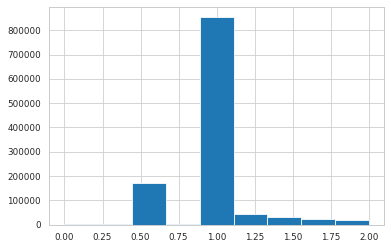

In [ ]:
seg_tri2020['RMI em SM'].hist(bins=np.linspace(0,2,10))

In [ ]:
# seg_tri2020['Mês'].replace({'Abril':4, 'Maio':5, 'Junho':6}, inplace=True)
# seg_tri2020['AnoNascimento']= pd.to_datetime(seg_tri2020['Dt Nascimento'], dayfirst=True, infer_datetime_format=True, errors='coerce').dt.year
# sns.regplot('AnoNascimento','RMI em SM', seg_tri2020[seg_tri2020['RMI em SM'] < 15], x_estimator=np.mean)
# benefs_CID['AnoNascimento']= pd.to_datetime(benefs_CID['Dt Nascimento'], dayfirst=True, infer_datetime_format=True, errors='coerce').dt.year
# sns.regplot('AnoNascimento','RMI em SM', benefs_CID[benefs_CID['RMI em SM'] < 15], x_estimator=np.log)

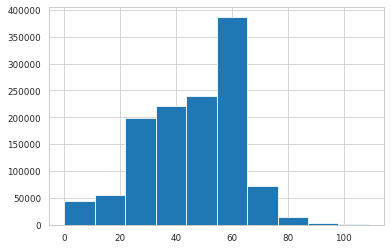

In [ ]:
seg_tri2020.Idade.hist();

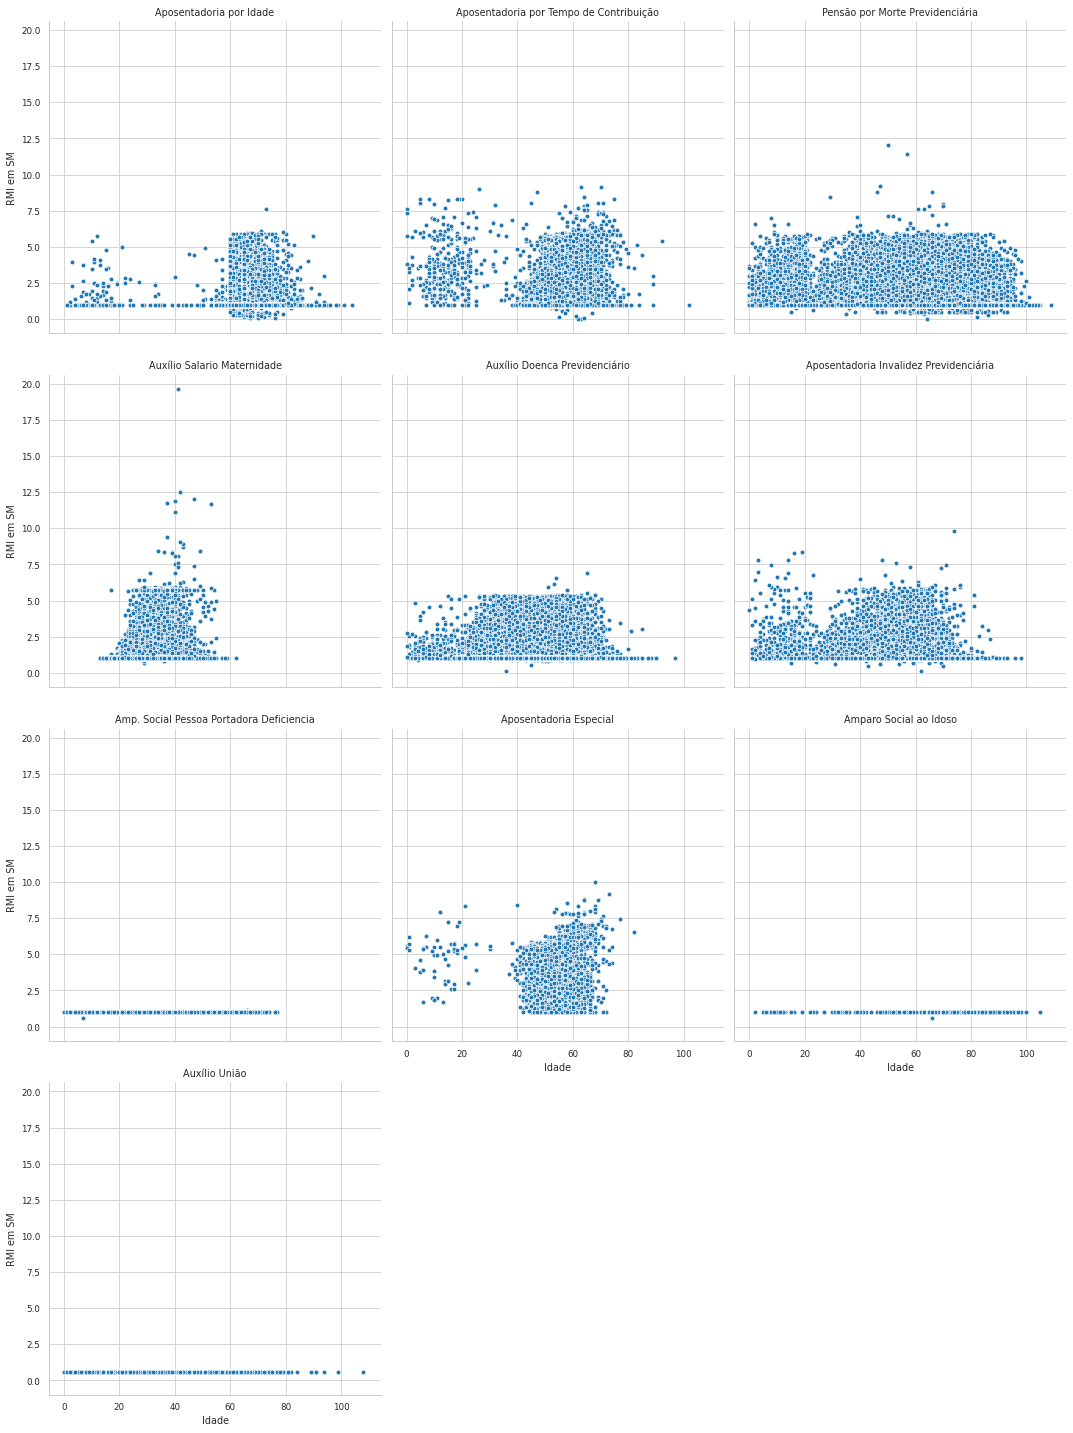

In [ ]:
g = sns.relplot('Idade', 'RMI em SM', data=dados_top10[dados_top10['RMI em SM']<30], col='Espécie', col_wrap=3);
g.set_titles('{col_name}');

In [ ]:
# popbr = pd.read_csv('formerge.csv', encoding='latin1', delimiter=';') # to do: upar planilha de população na nuvem

FileNotFoundError: ignored

In [ ]:
popbr = df.dropna().astype({'População':'int64'})
norte = 'Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins'.split(',')
nordeste = 'Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia'.split(',')
sudeste = 'Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo'.split(',')
centro_oeste = 'Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal'.split(',')
sul = 'Paraná,Santa Catarina,Rio Grande do Sul'.split(',')
regiões=[norte, nordeste, sudeste, centro_oeste, sul]
reg_names = 'Norte,Nordeste,Sudeste, Centro-oeste,Sul'.split(',')
for i, reg in zip(regiões, reg_names):
  popbr.loc[popbr['Unidade da Federação'].isin(i),'Região'] = reg

In [ ]:
# popbr

In [ ]:
pd.merge(seg_tri2020, popbr, left_on='UF', right_on='Unidade da Federação', indicator=True)['_merge'].value_counts()

In [54]:
print(norte, nordeste, sudeste, centro_oeste, sul) #checking

['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins'] ['Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia'] ['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo'] ['Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'] ['Paraná', 'Santa Catarina', 'Rio Grande do Sul']
